проект подготовил Соловьев Н.С. 


Задача - разработать и обучить ML модель предсказания стоимости автомобиля на вторичном рынке. Метрика MAPE

данные взяты с https://www.kaggle.com/competitions/used-cars-price-prediction-yap17/

План проекта:

- загрузка библиотек
- загрузка и обзор данных
- подготовка и анализ данных
- подготовка признаков для ml моделей
- построение моделей ml, подбор гиперпараметров
- выбор лучшей модели
- выбор  значимых признаков 
- общий вывод



* предварительно я обработал все признаки, не удалил вообще ничего и после обучения модели получил данные shap  в дальнейшем я буду работать только с полезными признаками.

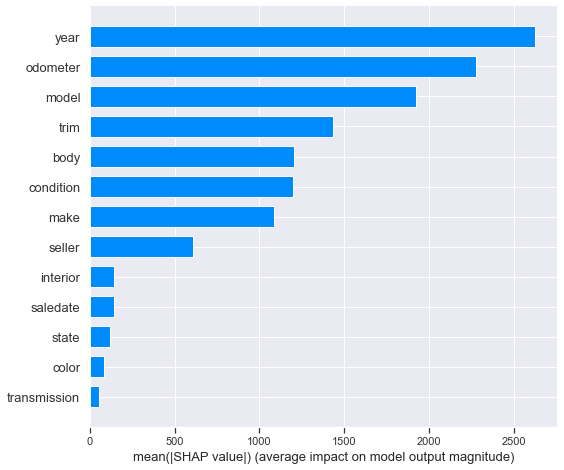

### Импортируем библиотеки

In [1]:
! pip install vininfo
! pip install scikit-learn --upgrade
! pip install category_encoders
! pip install shap
! pip3 install scikit-optimize
! pip install catboost
! pip install optuna

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import warnings
import os

from vininfo import Vin
from category_encoders import CatBoostEncoder
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold,train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import  RobustScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

### Загрузка и обзор данных.

In [3]:
pth = 'C:/Users/solov/AP/car.csv'

if os.path.exists(pth):
    df = pd.read_csv(pth)
else:
    print('Something is wrong')

In [4]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
None


In [5]:
df.sample(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
118004,2014,Ford,F-150,XLT,supercrew,automatic,1ftfw1et8efd13691,mi,5.0,7133.0,silver,gray,northway ford lincoln,30600,Thu Jun 04 2015 02:30:00 GMT-0700 (PDT)
44869,2014,Jeep,Cherokee,Latitude,SUV,automatic,1c4pjmcs9ew252611,mo,4.2,29313.0,red,black,budget rent a car/omaha,21700,Wed Dec 31 2014 10:30:00 GMT-0800 (PST)
418116,2013,Chrysler,Town and Country,Touring,minivan,automatic,2c4rc1bg5dr797310,ny,3.3,27382.0,black,black,chrysler capital,15000,Wed Jun 17 2015 03:15:00 GMT-0700 (PDT)


дф содержит 440236 строк и 16 колонок. 12 категориальный тип object 4 колличественных типы int и float. Целевой признак sellingprice

### Предобработка.

Сравним характеристики целевого признака распределения(mean, std, median) до и после заполнения, если изменения не критичны, тогда такое заполнение можно считать корректным. 

In [6]:
df['sellingprice'].describe()

count    440236.000000
mean      13592.209588
std        9751.479098
min           1.000000
25%        6900.000000
50%       12100.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

In [7]:
df.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

Пропуски будем заполнять модой/медианой группируя по другим признакам. Марку заполним по вину. Так же уберем все символы после пробела или наоборот объеденим их в одно слово если их много. Проведем ренейм признаком с неправильными именами и/или с именами дубликатами. Все значения приведем к нижнему регистру.

In [8]:
df['make'].value_counts()

Ford         73708
Chevrolet    47492
Nissan       42811
Toyota       31630
Dodge        24103
             ...  
Daewoo           1
dodge tk         1
mazda tk         1
dot              1
airstream        1
Name: make, Length: 92, dtype: int64

In [9]:
df['make'] = df['make'].fillna(df['vin'].map(lambda x: Vin(x).manufacturer))
df['make'] = df['make'] = df['make'].str.lower()
df.loc[(df.make=='land rover'),'make']='landrover'
df.loc[(df.make=='aston martin'),'make']='astonmartin'
df.loc[(df.make=='mercedes-b'),'make']='mercedes-benz'
df.loc[(df.make=='mercedes'),'make']='mercedes-benz'
df.loc[(df.make=='vw'),'make']='volkswagen'
df.loc[(df.make=='chev'),'make']='chevrolet'
df.loc[(df.make=='daimlerchrysler'),'make']='chrysler'
df['make'] = df.make.apply(lambda x:x.split(' ')[0])

In [10]:
df['make'].value_counts()

ford                75301
chevrolet           48924
nissan              43042
toyota              31915
dodge               24994
honda               21927
hyundai             17226
bmw                 16633
chrysler            14499
kia                 14360
mercedes-benz       13559
jeep                12367
infiniti            12123
volkswagen           9995
lexus                9691
gmc                  8471
mazda                7069
cadillac             6230
acura                4730
audi                 4670
lincoln              4641
buick                4047
subaru               4020
mitsubishi           3825
pontiac              3657
ram                  3592
volvo                2958
mini                 2473
saturn               2251
landrover            1880
mercury              1652
scion                1488
porsche              1178
jaguar               1103
suzuki                852
fiat                  674
hummer                598
saab                  386
oldsmobile  

In [11]:
df.loc[(df.make=='land rover'),'make']='landrover'
df.loc[(df.make=='aston martin'),'make']='astonmartin'
df.loc[(df.make=='mercedes-b'),'make']='mercedes-benz'
df.loc[(df.make=='mercedes'),'make']='mercedes-benz'
df.loc[(df.make=='vw'),'make']='volkswagen'
df.loc[(df.make=='chev'),'make']='chevrolet'
df.loc[(df.make=='daimlerchrysler'),'make']='chrysler'

In [12]:
df['model'].value_counts()

Altima           15454
F-150            11408
Fusion           10244
Camry             9996
Escape            9419
                 ...  
Civic del Sol        1
Tempo                1
Regency              1
8 Series             1
g500                 1
Name: model, Length: 959, dtype: int64

In [13]:
df['model'] = df['model'].str.lower()
df['model'] = df['model'].fillna(df.groupby(['make','sellingprice'])['model'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'unknown' ))
df['model'] = df.model.apply(lambda x:x.split(' ')[0])

In [14]:
df['model'].value_counts()

altima     15627
grand      12344
f-150      11654
fusion     10924
camry      10901
           ...  
subrbn         1
el             1
320i           1
x-trail        1
g500           1
Name: model, Length: 633, dtype: int64

In [15]:
df['trim'].value_counts()

Base                        43853
SE                          34465
LX                          16490
Limited                     14514
LT                          13374
                            ...  
2.3 Premium                     1
GLS V6 4Motion                  1
2500 High Ceiling 118 WB        1
Z71 SL                          1
4x4 v6 xlt sport                1
Name: trim, Length: 1922, dtype: int64

In [16]:
df_groupby = df.groupby(['condition','sellingprice'])['odometer'].transform('median')
df['odometer'] = df['odometer'].fillna(df_groupby)
df_groupby = df.groupby(['odometer','sellingprice'])['condition'].transform('median')
df['condition'] = df['condition'].fillna(df_groupby)
df_groupby = df.groupby(['year','sellingprice'])['odometer'].transform('median')
df['odometer'] = df['odometer'].fillna(df_groupby)
df_groupby = df.groupby(['year','sellingprice'])['condition'].transform('median')
df['condition'] = df['condition'].fillna(df_groupby)
df_groupby = df.groupby(['condition'])['odometer'].transform('median')
df['odometer'] = df['odometer'].fillna(df_groupby)
df_groupby = df.groupby(['odometer'])['condition'].transform('median')
df['condition'] = df['condition'].fillna(df_groupby)
df_groupby = df.groupby('year')['odometer'].transform('median')
df['odometer'] = df['odometer'].fillna(df_groupby)
df_groupby = df.groupby('year')['condition'].transform('median')
df['condition'] = df['condition'].fillna(df_groupby)

In [17]:
df['body'].value_counts()

Sedan              157639
SUV                 93633
sedan               33222
suv                 19409
Hatchback           16893
                    ...  
q60 convertible         2
Ram Van                 1
g37 coupe               1
cab plus 4              1
CTS-V Wagon             1
Name: body, Length: 85, dtype: int64

In [18]:
df['body'] = df['body'].str.lower()
df['body'] = df['body'].fillna(df.groupby('model')['body'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'unknown'))

In [19]:
def cat_body (row):
    if 'sedan' in row:
        return 'sedan'
    elif 'coupe' in row:
        return 'coupe'
    elif 'van' in row:
        return 'van'
    elif 'crew' in row or 'cab' in row:
        return 'crewcab'
    elif 'wagon' in row:
        return 'wagon'
    elif 'convertible' in row:
        return 'convertible'
    elif 'suv' in row:
        return 'suv'
    elif 'hatchback' in row:
        return 'hatchback'
    else:
        pass

In [20]:
df['body'] = df['body'].apply(cat_body)

In [21]:
df['body'].value_counts()

sedan          201864
suv            115259
crewcab         37765
van             26173
hatchback       20825
coupe           15771
wagon           13294
convertible      8661
Name: body, dtype: int64

In [22]:
df['body'] = df['body'].fillna(df.groupby('model')['body'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'unknown'))

In [23]:
df.isna().sum()

year                0
make                0
model               0
trim             8337
body                0
transmission    51461
vin                 0
state               0
condition           0
odometer            0
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

In [24]:
df['trim'].value_counts()

Base                        43853
SE                          34465
LX                          16490
Limited                     14514
LT                          13374
                            ...  
2.3 Premium                     1
GLS V6 4Motion                  1
2500 High Ceiling 118 WB        1
Z71 SL                          1
4x4 v6 xlt sport                1
Name: trim, Length: 1922, dtype: int64

In [25]:
df['trim'] = df['trim'].str.lower()
df['trim'] = df['trim'].fillna(df.groupby('model')['trim'].transform(lambda x: x.value_counts().index[0] if x.count() !=0 else 'unknown' ))
df['trim'] = df['trim'].apply(lambda x: ''.join(x.split()))          

In [26]:
df['trim'].value_counts()

base                  45408
se                    35130
lx                    16879
limited               14527
lt                    13816
                      ...  
selimited                 1
executivepzev             1
4cbase                    1
3500shceiling158wb        1
4x4v6xltsport             1
Name: trim, Length: 1831, dtype: int64

In [27]:
df['seller'].value_counts()

nissan-infiniti lt                15823
ford motor credit company,llc     15276
the hertz corporation             14692
santander consumer                12230
avis corporation                  10098
                                  ...  
bay shore motors                      1
thrifty rent a car systems inc        1
volvo of wichita                      1
wright way hyundai                    1
studio city auto group                1
Name: seller, Length: 13025, dtype: int64

In [28]:
df['seller']= df['seller'].str.lower()
df['seller'] = df['seller'].apply(lambda x: ''.join(x.split()))

In [29]:
df.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    51461
vin                 0
state               0
condition           0
odometer            0
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

рассмотрим основные статистические параметры

In [30]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
year,"440,236.00",NaN,NaN,NaN,"2,010.04",3.98,"1,982.00","2,007.00","2,012.00","2,013.00","2,015.00"
make,440236,59,ford,75301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,440236,633,altima,15627,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trim,440236,1831,base,45408,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body,440236,9,sedan,201999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,388775,2,automatic,375061,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vin,440236,440236,2fmdk3jc4bba41556,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,440236,38,fl,65618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,"440,236.00",NaN,NaN,NaN,3.41,0.95,1.00,2.70,3.60,4.20,5.00
odometer,"440,236.00",NaN,NaN,NaN,"68,354.22","53,547.36",1.00,"28,259.00","52,103.00","99,283.00","999,999.00"


В среднем в выборке продаются машины 2010 года, самая старая 1989 а новая 2015. Самая распространенная марка ford, модель altima , кузов седан. в среднем машины продают с заяленным состоянием около 3.5 баллов, пробегом 66000 миль и ценой около 14.000 у.е. Самый большой пробег 999.999 км почти миллион! а самый маленький 1,  можно сказать новый авто , нужно проверить на выбросы. Самая высокая цена 230.000 у.е , самая маленькая 1? Так же проверим. 

In [31]:
for row in df[['year', 'condition', 'odometer','sellingprice']]:
    Q1 = df[row].quantile(0.25)
    Q3 = df[row].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    if (df[(df[row] > upper)].any(axis=None)) & (df[(df[row] < lower)].any(axis=None)):
        print(row, ":выбросы есть")
    else:
        print(row, ":выбросов нет")

year :выбросов нет
condition :выбросов нет
odometer :выбросов нет
sellingprice :выбросов нет


In [32]:
df.query('sellingprice < 100')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
137962,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j73a269529,ga,2.10,1.00,black,black,peoplescreditcompanyinc,1,Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
418021,2002,ford,f-350,xlt,crewcab,NaN,1ftsw31f52ed16477,ca,2.00,"115,800.50",white,gray,laaleasing,1,Thu Feb 05 2015 04:00:00 GMT-0800 (PST)


In [33]:
df[['sellingprice','odometer']] = df[['sellingprice','odometer']].astype(int)

In [34]:
mers = df.loc[df['model'] == 'e-class', 'sellingprice'].median()
ford = df.loc[df['model'] == 'f-350', 'sellingprice'].median()
df.iloc[137962, df.columns.get_loc('sellingprice')] = mers
df.iloc[418021, df.columns.get_loc('sellingprice')] = ford

In [35]:
df.query('sellingprice > 200000')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
392004,2014,ford,escape,titanium,suv,automatic,1fmcu9j98eua23833,mo,4.30,27802,green,tan,ford-lincolndealerprogram,230000,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)


In [36]:
ford = df.loc[df['model'] == 'escape', 'sellingprice'].mean()
df.iloc[392004, df.columns.get_loc('sellingprice')] = ford

In [37]:
df['sellingprice'].describe()

count   440,236.00
mean     13,591.82
std       9,746.00
min         100.00
25%       6,900.00
50%      12,100.00
75%      18,200.00
max     183,000.00
Name: sellingprice, dtype: float64

пропуски заполнены корректно.

мультиколлинеарность, методом спирмена.

<AxesSubplot:>

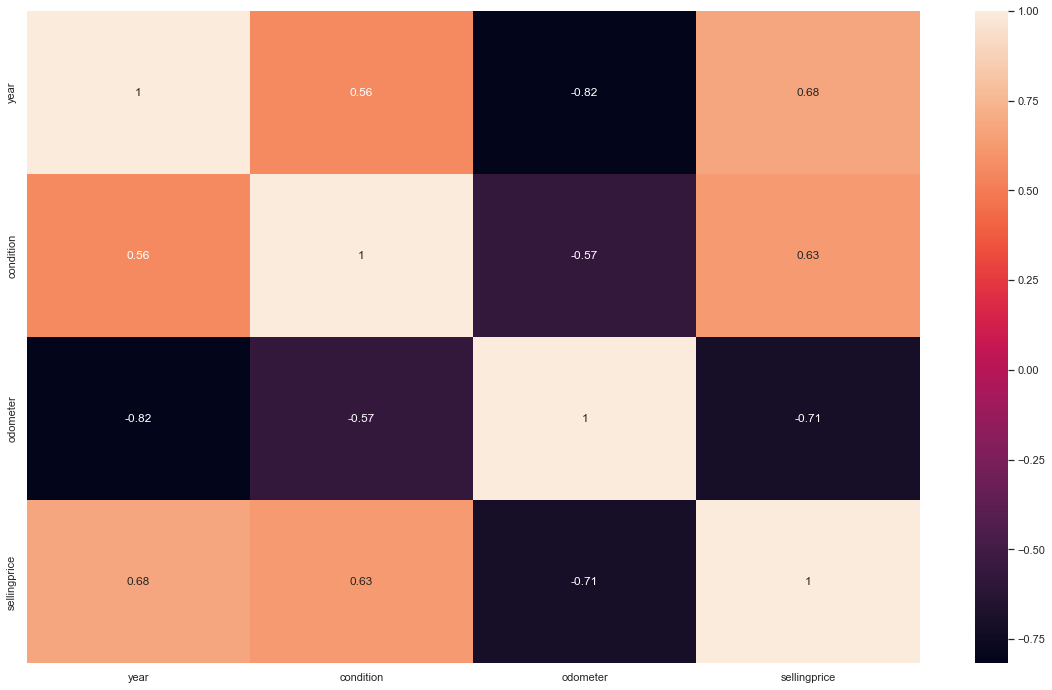

In [38]:
spearman = df.corr(method='spearman')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(data=spearman,annot=True)

### EDA

Посмотрим общее распределение.

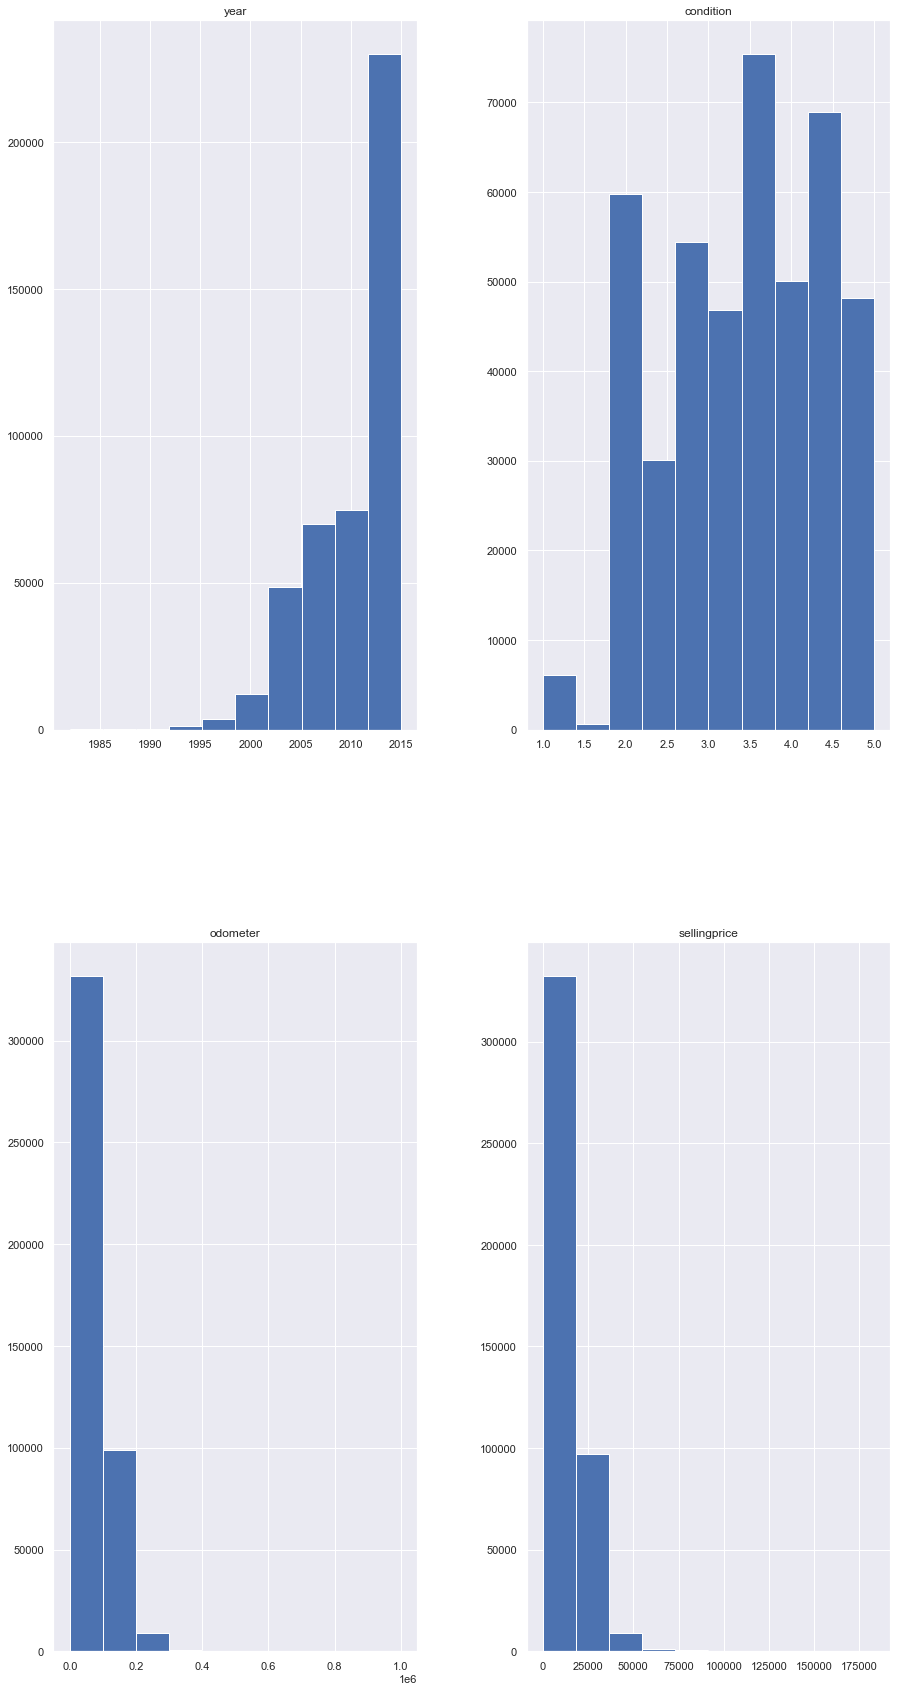

In [39]:
df.hist(figsize=(15, 30))
plt.show()

Здесь все соотвествует логике. распределение в основном логнормальное.

посмотрим на распределение относительно целевой переменной. 

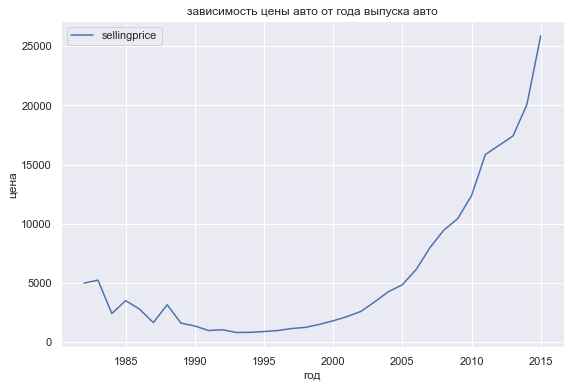

In [40]:
df.pivot_table(index='year', values='sellingprice').plot(title='зависимость цены авто от года выпуска авто', grid=True, style='-', figsize=(9, 6)).set(xlabel="год", ylabel="цена")
plt.show()

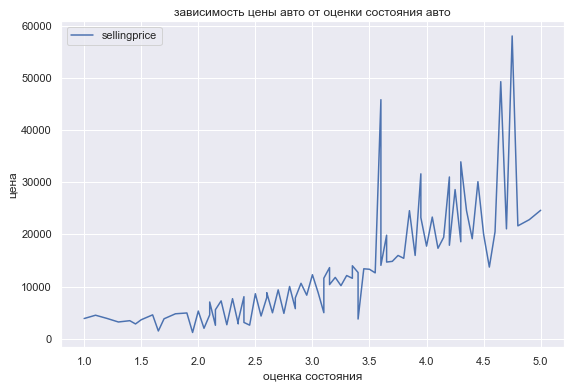

In [41]:
df.pivot_table(index='condition', values='sellingprice').plot(title='зависимость цены авто от оценки состояния авто', grid=True, style='-', figsize=(9, 6)).set(xlabel="оценка состояния", ylabel="цена")
plt.show()

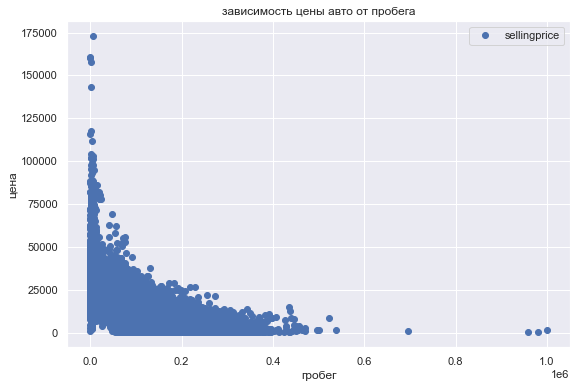

In [42]:
df.pivot_table(index='odometer', values='sellingprice').plot(title='зависимость цены авто от пробега', grid=True, style='o', figsize=(9, 6)).set(xlabel="гробег", ylabel="цена")
plt.show()

Все в общем соответсвует логике. Чем старше авто и больше пробег - тем ниже цена. Чем лучше оценивается его состояние - тем выше цена.

### Подготовка признаков 

In [43]:
RANDOM_STATE = 12345

target = df['sellingprice']
features = df.drop(['sellingprice','saledate', 'transmission', 'vin', 'state','color', 'interior'], axis=1)
features_train, features_test, target_train,target_test = train_test_split(features,target,test_size=.25,random_state=RANDOM_STATE)

print(features_train.shape)
print (target_train.shape)
print(features_test.shape)
print (target_test.shape)

(330177, 8)
(330177,)
(110059, 8)
(110059,)


### ML

масштабируем робустом тк данные явно содержат большой разброс. В качсетве кодировщика выбран целевой catboost, большое колличество уникальных значений. 

In [44]:
numeric = ['year', 'condition', 'odometer']
scaler = RobustScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

encoder = CatBoostEncoder(cols=['make', 'model', 'trim' ,'body', 'seller'])
features_train_encoded = encoder.fit_transform(features_train, target_train)
features_test_encoded = encoder.transform(features_test)
features_train = pd.concat([features_train_encoded, features_train[numeric]], axis=1)
features_test = pd.concat([features_test_encoded, features_test[numeric]], axis=1)
features_train = features_train.loc[:, ~features_train.columns.duplicated()]
features_test = features_test.loc[:, ~features_test.columns.duplicated()]

в качестве дамми модели можно использовать регрессию. Считает быстро,настройка не нужна.


In [45]:
lr = LinearRegression ().fit(features_train, target_train)

lr_pred = lr.predict(features_test)
lr_mape = mean_absolute_error(target_test, lr_pred) / np.mean(target_test)
print ('MAPE', lr_mape)

MAPE 0.22656903570506076


В качестве основной модели был выбран catboostregressor. 
Он должен быть быстрее хвбустинга и быстрее и точнее леса. Подбор гиперпараметров optuna с ограниением на 9 часов перебора.  
Будем использовать крос-валиацию 

In [48]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [2000, 3000]),
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.1, 1),
        'eval_metric': 'MAPE',
        'verbose': False
    }
    
    model = CatBoostRegressor(**params)
    
    mape_scores = []
    cv = KFold(n_splits=5, shuffle=True)
    
    for train_idx, val_idx in cv.split(features_train):
        train_features, val_features = features_train_encoded.iloc[train_idx], features_train_encoded.iloc[val_idx]
        train_target, val_target = target_train.iloc[train_idx], target_train.iloc[val_idx]
        
        model.fit(train_features, train_target, verbose=False)
        predictions = model.predict(val_features)
        mape = mean_absolute_percentage_error(val_target, predictions)
        mape_scores.append(mape)
    
    return np.mean(mape_scores)

study = optuna.create_study(direction='minimize')

study.optimize(objective, timeout=9*60*60)

print("Best hyperparameters:", study.best_params)

[I 2023-06-07 20:19:57,101] A new study created in memory with name: no-name-6cfa5922-d376-4a4d-ae6e-69ef4b9aecc9
[I 2023-06-07 20:28:23,300] Trial 0 finished with value: 0.4150057719140904 and parameters: {'n_estimators': 3000, 'max_depth': 11, 'learning_rate': 0.0013629914179779088, 'reg_lambda': 18.41425324597808, 'subsample': 0.5585065816825506, 'colsample_bylevel': 0.20828636071338885}. Best is trial 0 with value: 0.4150057719140904.
[I 2023-06-07 20:39:26,910] Trial 1 finished with value: 0.2000191919352413 and parameters: {'n_estimators': 2000, 'max_depth': 11, 'learning_rate': 0.010047249573313186, 'reg_lambda': 0.5486415907936552, 'subsample': 0.17883479763299365, 'colsample_bylevel': 0.4015310714990352}. Best is trial 1 with value: 0.2000191919352413.
[I 2023-06-07 20:51:43,862] Trial 2 finished with value: 0.17929579850848426 and parameters: {'n_estimators': 3000, 'max_depth': 10, 'learning_rate': 0.02960897620219832, 'reg_lambda': 1.1608846685015403e-05, 'subsample': 0.2916

[I 2023-06-08 05:38:58,986] Trial 24 finished with value: 0.17003962437742393 and parameters: {'n_estimators': 2000, 'max_depth': 12, 'learning_rate': 0.04647005889671169, 'reg_lambda': 4.728401510467268e-05, 'subsample': 0.6165211853883866, 'colsample_bylevel': 0.9953179625761479}. Best is trial 18 with value: 0.16918384826619273.


Best hyperparameters: {'n_estimators': 2000, 'max_depth': 12, 'learning_rate': 0.06171158954202019, 'reg_lambda': 9.228116120932947e-05, 'subsample': 0.6481359886254697, 'colsample_bylevel': 0.8428783845064598}


In [49]:
best_model = CatBoostRegressor(**study.best_params)
best_model.fit(features_train, target_train)
predictions = best_model.predict(features_test)
mape = mean_absolute_percentage_error(target_test, predictions)
print('MAPE:', mape)

0:	learn: 9271.8036745	total: 281ms	remaining: 9m 21s
1:	learn: 8833.3667824	total: 548ms	remaining: 9m 7s
2:	learn: 8428.4009271	total: 774ms	remaining: 8m 34s
3:	learn: 8053.7891406	total: 1.12s	remaining: 9m 19s
4:	learn: 7704.9520933	total: 1.44s	remaining: 9m 34s
5:	learn: 7380.2044950	total: 1.72s	remaining: 9m 33s
6:	learn: 7078.2422495	total: 2.03s	remaining: 9m 37s
7:	learn: 6797.8469425	total: 2.33s	remaining: 9m 39s
8:	learn: 6534.8889400	total: 2.61s	remaining: 9m 38s
9:	learn: 6292.4467900	total: 2.88s	remaining: 9m 33s
10:	learn: 6068.6250513	total: 3.18s	remaining: 9m 34s
11:	learn: 5858.9674902	total: 3.45s	remaining: 9m 31s
12:	learn: 5666.3050131	total: 3.71s	remaining: 9m 26s
13:	learn: 5489.2049695	total: 3.97s	remaining: 9m 23s
14:	learn: 5324.2010854	total: 4.26s	remaining: 9m 24s
15:	learn: 5168.9191732	total: 4.53s	remaining: 9m 22s
16:	learn: 5028.5020909	total: 4.78s	remaining: 9m 17s
17:	learn: 4899.6816178	total: 5.05s	remaining: 9m 16s
18:	learn: 4779.28954

150:	learn: 2756.3845827	total: 36.4s	remaining: 7m 25s
151:	learn: 2755.4379379	total: 36.6s	remaining: 7m 25s
152:	learn: 2752.3384922	total: 36.9s	remaining: 7m 24s
153:	learn: 2746.9072736	total: 37.1s	remaining: 7m 24s
154:	learn: 2745.0920151	total: 37.3s	remaining: 7m 24s
155:	learn: 2743.3780563	total: 37.5s	remaining: 7m 23s
156:	learn: 2741.5649524	total: 37.8s	remaining: 7m 23s
157:	learn: 2739.1048113	total: 38s	remaining: 7m 23s
158:	learn: 2735.0499657	total: 38.3s	remaining: 7m 22s
159:	learn: 2730.3219344	total: 38.5s	remaining: 7m 22s
160:	learn: 2726.5833062	total: 38.7s	remaining: 7m 22s
161:	learn: 2722.2712693	total: 38.9s	remaining: 7m 21s
162:	learn: 2721.1310472	total: 39.1s	remaining: 7m 20s
163:	learn: 2716.6222413	total: 39.4s	remaining: 7m 20s
164:	learn: 2714.1012828	total: 39.6s	remaining: 7m 20s
165:	learn: 2711.4836601	total: 39.8s	remaining: 7m 20s
166:	learn: 2707.9690499	total: 40.1s	remaining: 7m 20s
167:	learn: 2703.6008021	total: 40.3s	remaining: 7

298:	learn: 2389.1051152	total: 1m 10s	remaining: 6m 39s
299:	learn: 2386.5918958	total: 1m 10s	remaining: 6m 39s
300:	learn: 2385.2565364	total: 1m 10s	remaining: 6m 39s
301:	learn: 2384.5082078	total: 1m 10s	remaining: 6m 38s
302:	learn: 2382.2811606	total: 1m 11s	remaining: 6m 38s
303:	learn: 2381.1182404	total: 1m 11s	remaining: 6m 37s
304:	learn: 2380.0994308	total: 1m 11s	remaining: 6m 37s
305:	learn: 2378.5286296	total: 1m 11s	remaining: 6m 37s
306:	learn: 2377.0810412	total: 1m 12s	remaining: 6m 37s
307:	learn: 2375.2974288	total: 1m 12s	remaining: 6m 37s
308:	learn: 2374.2432466	total: 1m 12s	remaining: 6m 36s
309:	learn: 2371.7352253	total: 1m 12s	remaining: 6m 36s
310:	learn: 2370.1672023	total: 1m 12s	remaining: 6m 36s
311:	learn: 2368.9067771	total: 1m 13s	remaining: 6m 35s
312:	learn: 2367.9945064	total: 1m 13s	remaining: 6m 35s
313:	learn: 2366.6929770	total: 1m 13s	remaining: 6m 35s
314:	learn: 2365.2059039	total: 1m 13s	remaining: 6m 35s
315:	learn: 2364.0952679	total:

443:	learn: 2191.0538156	total: 1m 42s	remaining: 6m
444:	learn: 2189.9518939	total: 1m 43s	remaining: 6m
445:	learn: 2189.1065626	total: 1m 43s	remaining: 6m
446:	learn: 2187.9401617	total: 1m 43s	remaining: 6m
447:	learn: 2186.1502025	total: 1m 43s	remaining: 5m 59s
448:	learn: 2185.3859203	total: 1m 44s	remaining: 5m 59s
449:	learn: 2184.4051167	total: 1m 44s	remaining: 5m 59s
450:	learn: 2183.0158278	total: 1m 44s	remaining: 5m 59s
451:	learn: 2182.6415576	total: 1m 44s	remaining: 5m 58s
452:	learn: 2181.8152549	total: 1m 45s	remaining: 5m 58s
453:	learn: 2181.2513431	total: 1m 45s	remaining: 5m 58s
454:	learn: 2180.7167977	total: 1m 45s	remaining: 5m 58s
455:	learn: 2179.3220697	total: 1m 45s	remaining: 5m 57s
456:	learn: 2178.1953014	total: 1m 45s	remaining: 5m 57s
457:	learn: 2176.7719922	total: 1m 46s	remaining: 5m 57s
458:	learn: 2175.7029850	total: 1m 46s	remaining: 5m 57s
459:	learn: 2174.7841774	total: 1m 46s	remaining: 5m 56s
460:	learn: 2174.0418337	total: 1m 46s	remainin

588:	learn: 2060.9807039	total: 2m 15s	remaining: 5m 24s
589:	learn: 2060.1968309	total: 2m 15s	remaining: 5m 24s
590:	learn: 2059.1290632	total: 2m 16s	remaining: 5m 24s
591:	learn: 2057.5676332	total: 2m 16s	remaining: 5m 24s
592:	learn: 2056.7174284	total: 2m 16s	remaining: 5m 24s
593:	learn: 2055.9873976	total: 2m 16s	remaining: 5m 23s
594:	learn: 2055.5114203	total: 2m 16s	remaining: 5m 23s
595:	learn: 2054.6174833	total: 2m 17s	remaining: 5m 23s
596:	learn: 2053.6117898	total: 2m 17s	remaining: 5m 22s
597:	learn: 2052.7064467	total: 2m 17s	remaining: 5m 22s
598:	learn: 2051.6803334	total: 2m 17s	remaining: 5m 22s
599:	learn: 2050.9548194	total: 2m 18s	remaining: 5m 22s
600:	learn: 2050.5519169	total: 2m 18s	remaining: 5m 21s
601:	learn: 2049.6310395	total: 2m 18s	remaining: 5m 21s
602:	learn: 2048.3747259	total: 2m 18s	remaining: 5m 21s
603:	learn: 2047.5651500	total: 2m 19s	remaining: 5m 21s
604:	learn: 2046.4421871	total: 2m 19s	remaining: 5m 20s
605:	learn: 2045.4348983	total:

733:	learn: 1957.3274070	total: 2m 48s	remaining: 4m 50s
734:	learn: 1956.5761977	total: 2m 48s	remaining: 4m 50s
735:	learn: 1956.1931949	total: 2m 49s	remaining: 4m 50s
736:	learn: 1955.6242409	total: 2m 49s	remaining: 4m 50s
737:	learn: 1954.7130408	total: 2m 49s	remaining: 4m 49s
738:	learn: 1954.4108454	total: 2m 49s	remaining: 4m 49s
739:	learn: 1954.0100371	total: 2m 49s	remaining: 4m 49s
740:	learn: 1953.1577248	total: 2m 50s	remaining: 4m 49s
741:	learn: 1952.4790237	total: 2m 50s	remaining: 4m 48s
742:	learn: 1951.7960935	total: 2m 50s	remaining: 4m 48s
743:	learn: 1951.4136095	total: 2m 50s	remaining: 4m 48s
744:	learn: 1950.6910566	total: 2m 51s	remaining: 4m 48s
745:	learn: 1950.3499070	total: 2m 51s	remaining: 4m 47s
746:	learn: 1949.7492011	total: 2m 51s	remaining: 4m 47s
747:	learn: 1949.1165647	total: 2m 51s	remaining: 4m 47s
748:	learn: 1948.3730549	total: 2m 51s	remaining: 4m 47s
749:	learn: 1948.0583197	total: 2m 52s	remaining: 4m 47s
750:	learn: 1947.6834249	total:

878:	learn: 1876.3197085	total: 3m 21s	remaining: 4m 17s
879:	learn: 1875.6779797	total: 3m 21s	remaining: 4m 16s
880:	learn: 1875.1607153	total: 3m 22s	remaining: 4m 16s
881:	learn: 1874.7686775	total: 3m 22s	remaining: 4m 16s
882:	learn: 1874.4780626	total: 3m 22s	remaining: 4m 16s
883:	learn: 1873.9575173	total: 3m 22s	remaining: 4m 15s
884:	learn: 1873.3881047	total: 3m 23s	remaining: 4m 15s
885:	learn: 1873.0481355	total: 3m 23s	remaining: 4m 15s
886:	learn: 1872.6109071	total: 3m 23s	remaining: 4m 15s
887:	learn: 1872.2697183	total: 3m 23s	remaining: 4m 15s
888:	learn: 1871.9343925	total: 3m 23s	remaining: 4m 14s
889:	learn: 1871.1879611	total: 3m 24s	remaining: 4m 14s
890:	learn: 1870.7741457	total: 3m 24s	remaining: 4m 14s
891:	learn: 1870.2368016	total: 3m 24s	remaining: 4m 14s
892:	learn: 1869.9345868	total: 3m 24s	remaining: 4m 13s
893:	learn: 1869.4332713	total: 3m 24s	remaining: 4m 13s
894:	learn: 1868.7050104	total: 3m 25s	remaining: 4m 13s
895:	learn: 1868.2810829	total:

1023:	learn: 1809.7613667	total: 3m 54s	remaining: 3m 43s
1024:	learn: 1809.3682160	total: 3m 54s	remaining: 3m 43s
1025:	learn: 1808.7292045	total: 3m 54s	remaining: 3m 43s
1026:	learn: 1808.4959289	total: 3m 55s	remaining: 3m 42s
1027:	learn: 1808.3072389	total: 3m 55s	remaining: 3m 42s
1028:	learn: 1807.9100036	total: 3m 55s	remaining: 3m 42s
1029:	learn: 1807.5861008	total: 3m 55s	remaining: 3m 42s
1030:	learn: 1807.2887986	total: 3m 56s	remaining: 3m 41s
1031:	learn: 1806.7410223	total: 3m 56s	remaining: 3m 41s
1032:	learn: 1806.4361261	total: 3m 56s	remaining: 3m 41s
1033:	learn: 1806.1460194	total: 3m 56s	remaining: 3m 41s
1034:	learn: 1805.7468789	total: 3m 56s	remaining: 3m 40s
1035:	learn: 1805.2395787	total: 3m 57s	remaining: 3m 40s
1036:	learn: 1804.9416041	total: 3m 57s	remaining: 3m 40s
1037:	learn: 1804.5927675	total: 3m 57s	remaining: 3m 40s
1038:	learn: 1804.1941170	total: 3m 57s	remaining: 3m 40s
1039:	learn: 1803.4672762	total: 3m 58s	remaining: 3m 39s
1040:	learn: 1

1166:	learn: 1752.4708536	total: 4m 27s	remaining: 3m 10s
1167:	learn: 1752.2494753	total: 4m 27s	remaining: 3m 10s
1168:	learn: 1751.8828125	total: 4m 27s	remaining: 3m 10s
1169:	learn: 1751.3384269	total: 4m 27s	remaining: 3m 10s
1170:	learn: 1750.8785554	total: 4m 28s	remaining: 3m 9s
1171:	learn: 1750.5316511	total: 4m 28s	remaining: 3m 9s
1172:	learn: 1750.1663131	total: 4m 28s	remaining: 3m 9s
1173:	learn: 1749.8570093	total: 4m 28s	remaining: 3m 9s
1174:	learn: 1749.5166610	total: 4m 29s	remaining: 3m 8s
1175:	learn: 1749.0689414	total: 4m 29s	remaining: 3m 8s
1176:	learn: 1748.6030527	total: 4m 29s	remaining: 3m 8s
1177:	learn: 1748.1227238	total: 4m 29s	remaining: 3m 8s
1178:	learn: 1747.8302428	total: 4m 29s	remaining: 3m 7s
1179:	learn: 1747.6180674	total: 4m 30s	remaining: 3m 7s
1180:	learn: 1747.4172665	total: 4m 30s	remaining: 3m 7s
1181:	learn: 1747.2869534	total: 4m 30s	remaining: 3m 7s
1182:	learn: 1747.0192350	total: 4m 30s	remaining: 3m 7s
1183:	learn: 1746.7497329	t

1309:	learn: 1705.1807168	total: 4m 59s	remaining: 2m 37s
1310:	learn: 1705.0115285	total: 4m 59s	remaining: 2m 37s
1311:	learn: 1704.7049759	total: 5m	remaining: 2m 37s
1312:	learn: 1704.4276664	total: 5m	remaining: 2m 37s
1313:	learn: 1704.0764663	total: 5m	remaining: 2m 36s
1314:	learn: 1703.9149179	total: 5m	remaining: 2m 36s
1315:	learn: 1703.5618958	total: 5m	remaining: 2m 36s
1316:	learn: 1703.1718478	total: 5m 1s	remaining: 2m 36s
1317:	learn: 1703.0016525	total: 5m 1s	remaining: 2m 35s
1318:	learn: 1702.5177684	total: 5m 1s	remaining: 2m 35s
1319:	learn: 1702.1051967	total: 5m 1s	remaining: 2m 35s
1320:	learn: 1701.7856493	total: 5m 2s	remaining: 2m 35s
1321:	learn: 1701.2375525	total: 5m 2s	remaining: 2m 35s
1322:	learn: 1701.0421964	total: 5m 2s	remaining: 2m 34s
1323:	learn: 1700.7355395	total: 5m 2s	remaining: 2m 34s
1324:	learn: 1700.4759104	total: 5m 2s	remaining: 2m 34s
1325:	learn: 1700.3148055	total: 5m 3s	remaining: 2m 34s
1326:	learn: 1699.8860879	total: 5m 3s	remai

1452:	learn: 1659.0414806	total: 5m 32s	remaining: 2m 5s
1453:	learn: 1658.7380632	total: 5m 32s	remaining: 2m 4s
1454:	learn: 1658.3395371	total: 5m 32s	remaining: 2m 4s
1455:	learn: 1658.1233933	total: 5m 33s	remaining: 2m 4s
1456:	learn: 1658.0146249	total: 5m 33s	remaining: 2m 4s
1457:	learn: 1657.6583296	total: 5m 33s	remaining: 2m 3s
1458:	learn: 1657.3800681	total: 5m 33s	remaining: 2m 3s
1459:	learn: 1657.1431690	total: 5m 33s	remaining: 2m 3s
1460:	learn: 1656.7719121	total: 5m 34s	remaining: 2m 3s
1461:	learn: 1656.5032418	total: 5m 34s	remaining: 2m 3s
1462:	learn: 1656.2235231	total: 5m 34s	remaining: 2m 2s
1463:	learn: 1655.7263013	total: 5m 34s	remaining: 2m 2s
1464:	learn: 1655.2824015	total: 5m 35s	remaining: 2m 2s
1465:	learn: 1654.9837768	total: 5m 35s	remaining: 2m 2s
1466:	learn: 1654.6076851	total: 5m 35s	remaining: 2m 1s
1467:	learn: 1654.1437974	total: 5m 35s	remaining: 2m 1s
1468:	learn: 1653.7858961	total: 5m 36s	remaining: 2m 1s
1469:	learn: 1653.5081279	total

1595:	learn: 1616.5552394	total: 6m 5s	remaining: 1m 32s
1596:	learn: 1616.1759582	total: 6m 5s	remaining: 1m 32s
1597:	learn: 1615.7553951	total: 6m 5s	remaining: 1m 31s
1598:	learn: 1615.4733929	total: 6m 5s	remaining: 1m 31s
1599:	learn: 1615.3214561	total: 6m 6s	remaining: 1m 31s
1600:	learn: 1615.1999631	total: 6m 6s	remaining: 1m 31s
1601:	learn: 1615.0397874	total: 6m 6s	remaining: 1m 31s
1602:	learn: 1614.7554210	total: 6m 6s	remaining: 1m 30s
1603:	learn: 1614.6446949	total: 6m 6s	remaining: 1m 30s
1604:	learn: 1614.4173728	total: 6m 7s	remaining: 1m 30s
1605:	learn: 1614.2406275	total: 6m 7s	remaining: 1m 30s
1606:	learn: 1613.9163208	total: 6m 7s	remaining: 1m 29s
1607:	learn: 1613.5665911	total: 6m 7s	remaining: 1m 29s
1608:	learn: 1613.2365656	total: 6m 8s	remaining: 1m 29s
1609:	learn: 1613.1119044	total: 6m 8s	remaining: 1m 29s
1610:	learn: 1612.8533170	total: 6m 8s	remaining: 1m 29s
1611:	learn: 1612.6315972	total: 6m 8s	remaining: 1m 28s
1612:	learn: 1612.3718157	total

1738:	learn: 1579.1368224	total: 6m 37s	remaining: 59.7s
1739:	learn: 1578.7980754	total: 6m 37s	remaining: 59.5s
1740:	learn: 1578.5211138	total: 6m 38s	remaining: 59.2s
1741:	learn: 1578.2260649	total: 6m 38s	remaining: 59s
1742:	learn: 1578.0218783	total: 6m 38s	remaining: 58.8s
1743:	learn: 1577.8212528	total: 6m 38s	remaining: 58.5s
1744:	learn: 1577.7427284	total: 6m 39s	remaining: 58.3s
1745:	learn: 1577.4809560	total: 6m 39s	remaining: 58.1s
1746:	learn: 1577.2254679	total: 6m 39s	remaining: 57.9s
1747:	learn: 1576.8737543	total: 6m 39s	remaining: 57.6s
1748:	learn: 1576.6095908	total: 6m 39s	remaining: 57.4s
1749:	learn: 1576.3898779	total: 6m 40s	remaining: 57.2s
1750:	learn: 1576.2205023	total: 6m 40s	remaining: 56.9s
1751:	learn: 1575.9779744	total: 6m 40s	remaining: 56.7s
1752:	learn: 1575.6802059	total: 6m 40s	remaining: 56.5s
1753:	learn: 1575.5590645	total: 6m 41s	remaining: 56.3s
1754:	learn: 1575.1875680	total: 6m 41s	remaining: 56s
1755:	learn: 1574.8272636	total: 6m

1884:	learn: 1542.8011409	total: 7m 11s	remaining: 26.3s
1885:	learn: 1542.5040119	total: 7m 11s	remaining: 26.1s
1886:	learn: 1542.3587097	total: 7m 11s	remaining: 25.8s
1887:	learn: 1541.8930253	total: 7m 11s	remaining: 25.6s
1888:	learn: 1541.6384738	total: 7m 12s	remaining: 25.4s
1889:	learn: 1541.4282069	total: 7m 12s	remaining: 25.2s
1890:	learn: 1541.1210475	total: 7m 12s	remaining: 24.9s
1891:	learn: 1540.9755029	total: 7m 12s	remaining: 24.7s
1892:	learn: 1540.6816335	total: 7m 12s	remaining: 24.5s
1893:	learn: 1540.4558270	total: 7m 13s	remaining: 24.2s
1894:	learn: 1540.1536375	total: 7m 13s	remaining: 24s
1895:	learn: 1540.0023610	total: 7m 13s	remaining: 23.8s
1896:	learn: 1539.6924626	total: 7m 13s	remaining: 23.6s
1897:	learn: 1539.4202664	total: 7m 14s	remaining: 23.3s
1898:	learn: 1539.2244877	total: 7m 14s	remaining: 23.1s
1899:	learn: 1539.1410445	total: 7m 14s	remaining: 22.9s
1900:	learn: 1538.9082295	total: 7m 14s	remaining: 22.6s
1901:	learn: 1538.5589573	total: 

### Вывод.

Была построена модель предсказвающая цену б/у авто. Данные 'грязные', много пропусков.  Для заполнения использовали моду/медиану с группировкой. Не все признаки оказались значимы для модели. Признаки подготовили robustscaler и catboostencoder, модель catboostregresoor - на выходе получили MAPE ~16%. Клиенты ,которые размещают объявления - смогут ориентироваться на предложенную цену для более быстрой продажи, клиенты которые выбирают а/м для покупки будут видеть насколько цена продавца соответсвует рекомендуемой.  